# Generating galaxy pointclouds from the CAMELS hdyro simulations

To demonstrate the flexiblity of diffusion models to work on any data modality, we'll work on an implementation to generate galaxy 3D pointclouds from the CAMELS simulations. 

Let's look at the dataset first.

In [1]:
import numpy as np
from pathlib import Path

data_dir = Path('/ocean/projects/phy230064p/shared/camels')

galaxy_features = np.load(data_dir / 'pointclouds/galaxy_features.npy')
mask = galaxy_features[...,-1]
galaxy_features = galaxy_features[...,:-1]
print(galaxy_features.shape)

(1000, 1032, 8)


so we have 1000 independent simulations, with a maximum of 1032 galaxies in each simulation. Padding with zeros has been used to denote there isn't a galaxy, this information will be stored in mask. There are 8 features per galaxy:

x, y, z, star formation rate, vx, vy, vz, stellar mass


I would start generating x, y and z positions. But have some fun trying to model the entire space!

In [2]:
# let's have a look at the different cosmological and astro parameters that generated the 1000 simulations
import pandas as pd

pd.read_csv(data_dir / 'params.txt', names=['Omega_m', 'sigma_8', 'A_sn1', 'A_sn2', 'A_agn1', 'A_agn2'], sep=' ')


,Omega_m,sigma_8,A_sn1,A_sn2,A_agn1,A_agn2
0,0.3090,0.9790,3.11234,1.12194,0.66850,0.53182
1,0.3026,0.9394,3.42001,3.96137,1.03311,1.16070
2,0.4282,0.7530,0.70613,0.37423,1.96292,0.62720
3,0.1906,0.6286,1.60882,0.39887,0.86634,0.86634
4,0.1382,0.6874,1.19914,0.27586,0.82188,0.91700
...,...,...,...,...,...,...
995,0.1342,0.7202,0.48163,0.25174,1.74231,0.76684
996,0.1854,0.7978,0.30566,1.79751,1.51887,0.53403
997,0.1582,0.7854,0.93952,2.23148,1.85446,1.32961
998,0.3854,0.9778,0.93692,0.42869,1.48761,1.32042


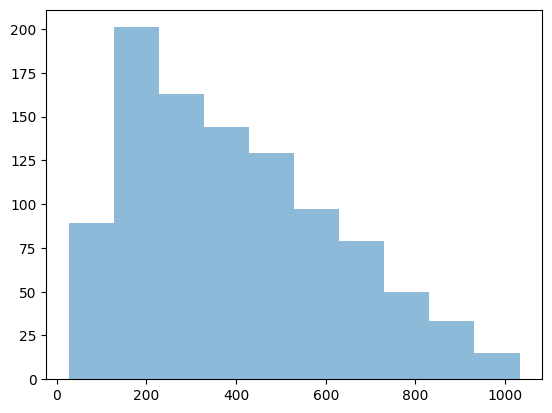

In [3]:
# let's look at the number of galaxies per simulation
import matplotlib.pyplot as plt
n_galaxies = np.sum(mask,axis=-1)

_ = plt.hist(n_galaxies, alpha=0.5)

/tmp/ipykernel_52508/303840160.py:4: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(galaxy_features[0, :, 0], galaxy_features[0, :, 1], galaxy_features[0, :, 2], s=10, c=np.log10(galaxy_features[0,:,-1]))


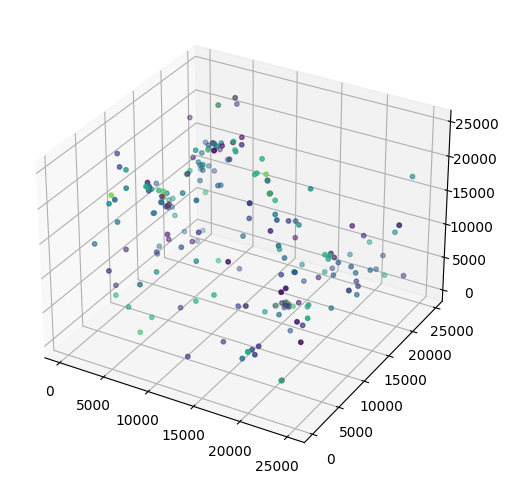

In [4]:
# let's look at the galaxy positions from one simulation colored by stellar mass
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(galaxy_features[0, :, 0], galaxy_features[0, :, 1], galaxy_features[0, :, 2], s=10, c=np.log10(galaxy_features[0,:,-1]))

plt.show()

In [ ]:
# you can see the boxsize is about 250_000 kpc/h 
# remember these are simiulations in periodic boxes!

In [6]:

import torch
from torch.utils.data import TensorDataset, DataLoader

data_tensor = torch.tensor(galaxy_features, dtype=torch.float32)
mask_tensor = torch.tensor(mask, dtype=torch.bool)

dataset = TensorDataset(data_tensor, mask_tensor)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

def tuple_to_dict(batch):
    return {'data': batch[0], 'mask': batch[1]}

# This is how you can use it
for batch in dataloader:
    batch_dict = tuple_to_dict(batch)
    print(batch_dict['data'].shape, batch_dict['mask'].shape)
    break

torch.Size([4, 1032, 8]) torch.Size([4, 1032])


As opposed to the previous example, we are now dealing with pointcloud objects, so we can't use a convolutional network as denoising model. We need a model that is permutation invariant. Graph neural networks and transformers would be a good start :) 

Also, keep in mind that the loss function needs to be masked to account for varying number of nodes!

Have a look at the [jax code](https://github.com/smsharma/point-cloud-galaxy-diffusion) for a similar model implemented for dark matter halos in [this paper](https://arxiv.org/abs/2311.17141), 